### Objective
The task is to forecast the total amount of products sold in every shop for the test set. Note that the list of shops and products slightly changes every month.

#### Data Description

- ID - an Id that represents a (Shop, Item) tuple within the test set
- shop_id - unique identifier of a shop
- item_id - unique identifier of a product
- item_category_id - unique identifier of item category
- item_cnt_day - number of products sold. You are predicting a monthly amount of this measure
- item_price - current price of an item
- date - date in format dd/mm/yyyy
- date_block_num - a consecutive month number, used for convenience. - January 2013 is 0, February 2013 is 1,..., October 2015 is 33
- item_name - name of item
- shop_name - name of shop
- item_category_name - name of item category

In [1]:
import warnings
warnings.filterwarnings("ignore")

import os
from os.path import join

import pandas as pd
import numpy as np

import missingno as msno # 결측 데이터 확인

from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import KFold, cross_val_score
import xgboost as xgb  # 회귀모델 구현
import lightgbm as lgb  # 회귀모델 구현

import matplotlib.pyplot as plt
import seaborn as sns

import datetime # 필요
from statsmodels.tsa.arima_model import ARIMA # 시계열 모델

In [2]:
train_data_path = join('../input', 'sales_train.csv')
sub_data_path = join('../input', 'test.csv')

In [3]:
data_dir = os.getenv('HOME')+'/workplace/aiffel/Exploration/hackathon/data'
train_data_path = join(data_dir, 'sales_train.csv')
sub_data_path = join(data_dir, 'test.csv')

print(train_data_path)
print(sub_data_path)

/home/aiffel0047/workplace/aiffel/Exploration/hackathon/data/sales_train.csv
/home/aiffel0047/workplace/aiffel/Exploration/hackathon/data/test.csv


In [4]:
data = pd.read_csv(train_data_path)
sub = pd.read_csv(sub_data_path)
print('train data dim : {}'.format(data.shape))
print('sub data dim : {}'.format(sub.shape))

train data dim : (2935849, 6)
sub data dim : (214200, 3)


In [5]:
# 타겟 변수 지정
y = data['item_cnt_day']
del data['item_cnt_day']

In [6]:
# 전체 데이터 탐색을 위해 학습 데이터와 테스트 데이터 합치기
train_len = len(data) # 추후 재분리 위해 인덱스 확인
data = pd.concat((data, sub), axis = 0)
print(len(data))

3150049


In [7]:
data.head() # data 타입 수정 필요, data_block_num 

,date,date_block_num,shop_id,item_id,item_price,ID
0,02.01.2013,0.0,59,22154,999.00,NaN
1,03.01.2013,0.0,25,2552,899.00,NaN
2,05.01.2013,0.0,25,2552,899.00,NaN
3,06.01.2013,0.0,25,2554,1709.05,NaN
4,15.01.2013,0.0,25,2555,1099.00,NaN


In [ ]:
# data 타입 수정 필요
# datetime 이용

In [ ]:
# data_block_num 은 월별 표현이기 때문에 groupby를 한다거나 전처리 필요
# 다른 사람 코드 참고
# monthly_sales=sales.groupby(["date_block_num","shop_id","item_id"])[
    # "date","item_price","item_cnt_day"].agg({"date":["min",'max'],"item_price":"mean","item_cnt_day":"sum"})

In [ ]:
# ID NaN 결측값: test set에만 있기 때문에 train 데이터에는 없음

In [8]:
data['ID']

0              NaN
1              NaN
2              NaN
3              NaN
4              NaN
            ...   
214195    214195.0
214196    214196.0
214197    214197.0
214198    214198.0
214199    214199.0
Name: ID, Length: 3150049, dtype: float64

#### 전처리

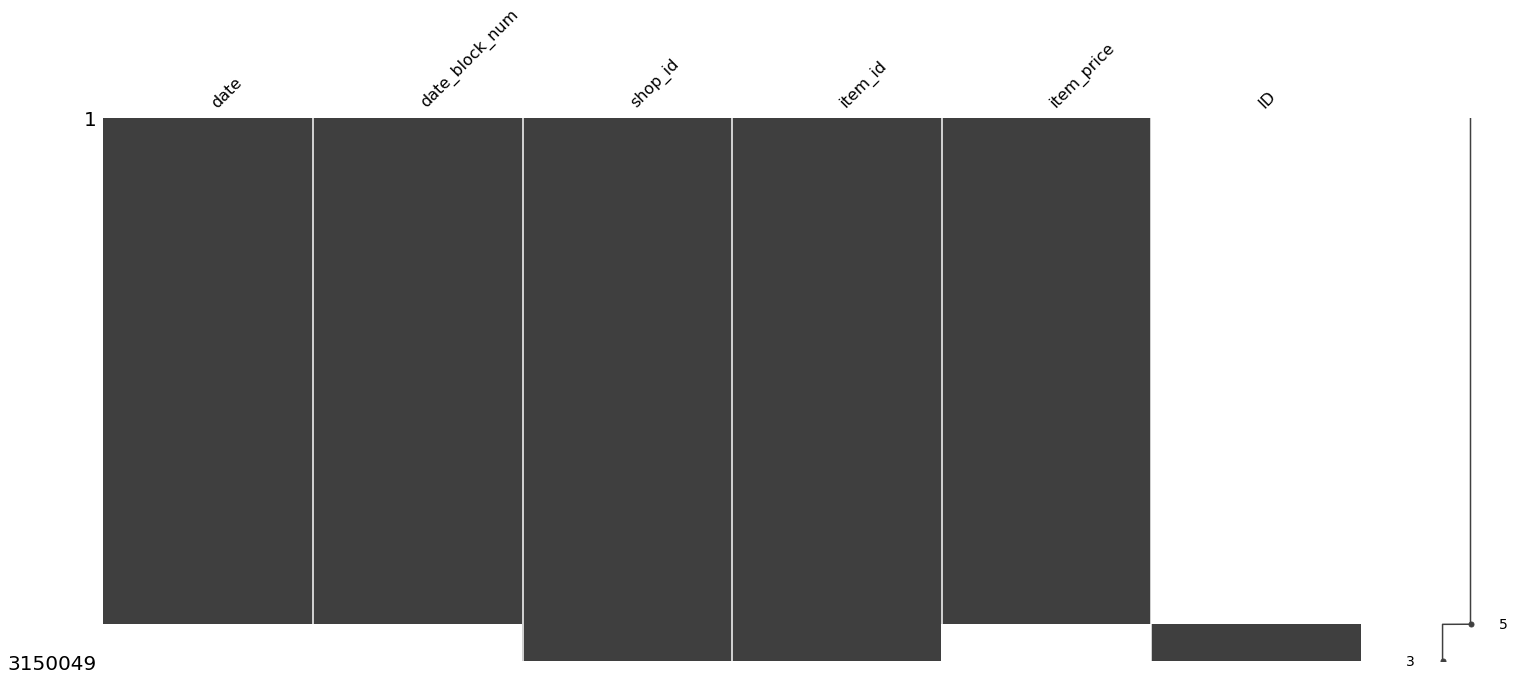

In [9]:
# 전처리 시각화
msno.matrix(data)

In [11]:
for c in data.columns:
    print('{} : {}'.format(c, len(data.loc[pd.isnull(data[c]), c].values)))

date : 214200
date_block_num : 214200
shop_id : 0
item_id : 0
item_price : 214200
ID : 2935849


In [ ]:
# 결측치 수치 이상..

#### id, date 변수 정리

In [14]:
sub_id = data['ID'][train_len:] # 만일을 대비하여 저장
del data['ID']

print(data.columns)

Index(['date', 'date_block_num', 'shop_id', 'item_id', 'item_price'], dtype='object')


In [15]:
# date: 연월만 사용할건지 일도 사용할건지, 연월만 사용할 경우 필요한 함수만 잘라낼 필요 있음
# data['date'] = data['date'].apply(lambda x : str(x[:6]))

# data.head()

pandas.core.series.Series

ValueError: could not convert string to float: '02.01.2013'

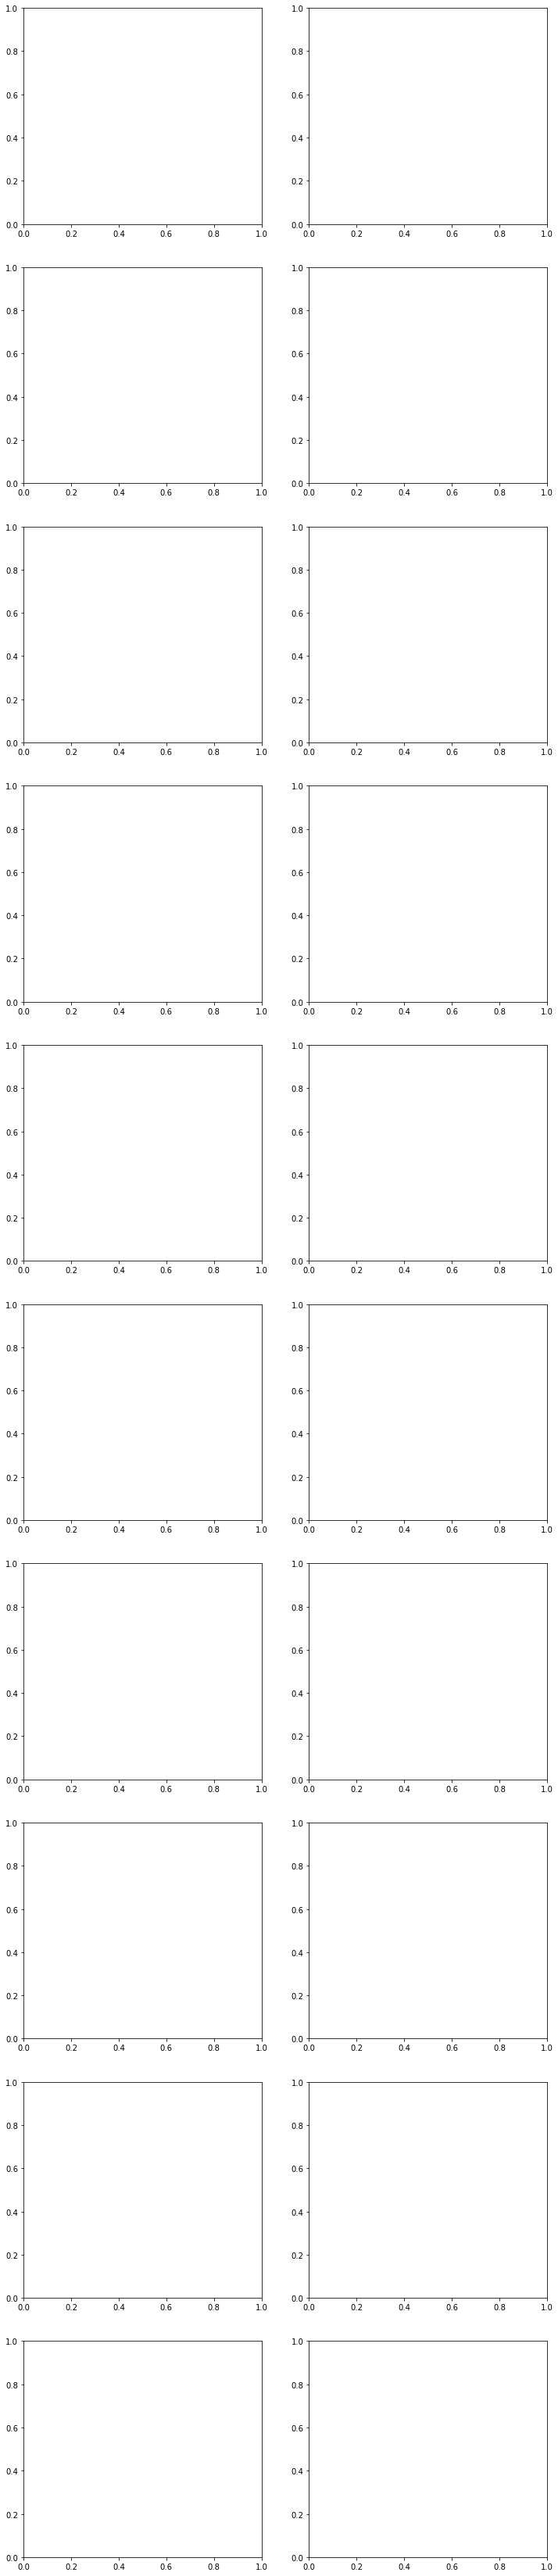

In [16]:
fig, ax = plt.subplots(10, 2, figsize=(12, 60))   # 가로스크롤 때문에 그래프 확인이 불편하다면 figsize의 x값을 조절해 보세요. 

# id 변수는 제외하고 분포를 확인합니다.
count = 0
columns = data.columns
for row in range(10):
    for col in range(2):
        sns.kdeplot(data[columns[count]], ax=ax[row][col])
        ax[row][col].set_title(columns[count], fontsize=15)
        count += 1
        if count == 19 :
            break